# Compute Rt for Haredim cities (Bnei-Brak, Elad, Modiin-Ilit, Beitar-Ilit)

In [1]:
%load_ext autoreload
%autoreload 2

import pymc3 as pm
import pandas as pd
import numpy as np
import arviz as az
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
from matplotlib import pyplot as plt
from covid.models.generative import GenerativeModel
from covid.data import summarize_inference_data
%config InlineBackend.figure_format = 'retina'

from covid.data import get_and_process_covidtracking_data_il, get_and_process_covidtracking_data_ilsev, summarize_inference_data

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-dh07g7l7 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
dfcit = get_and_process_covidtracking_data_il(run_date=pd.Timestamp.today(), norm=False, cities=True)
bb = ['6100', '3780', '3797', '1309', '1137']
model_bb = dfcit.loc[bb].groupby('date').sum()
gmbb = GenerativeModel(bb, model_bb, buffer_days = 10, delay=2, sigma=0.07)
gmbb.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 1558 seconds.


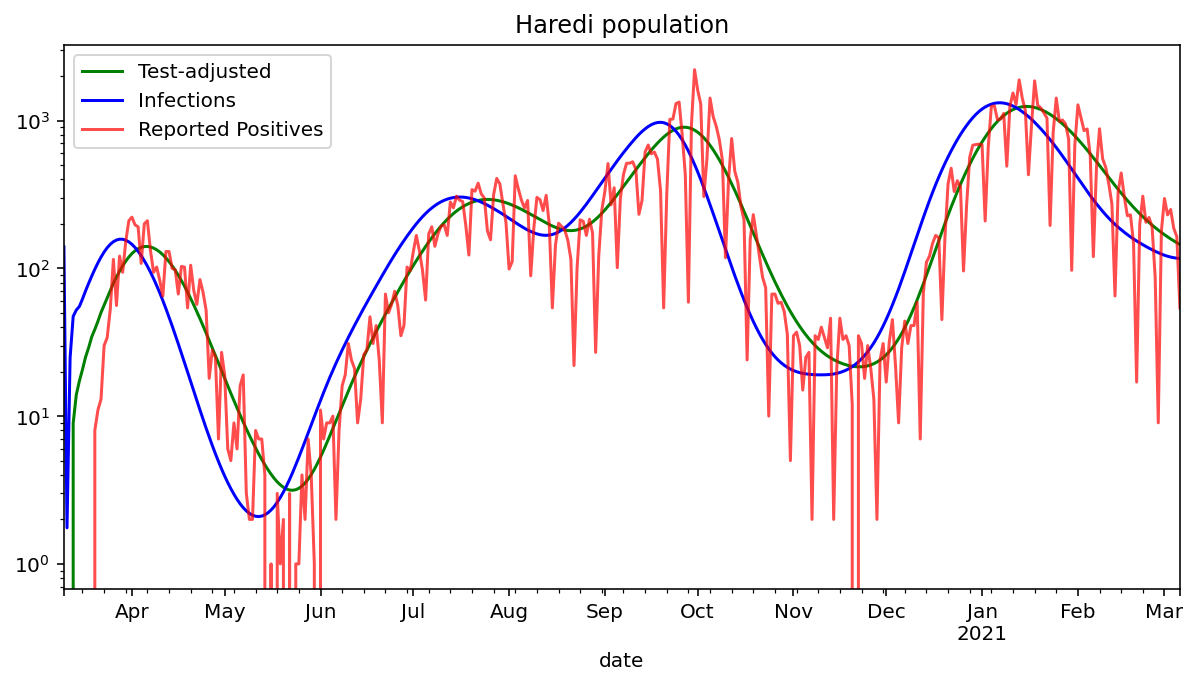

In [3]:
resultbb = summarize_inference_data(gmbb.inference_data)

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title("Haredi population")
resultbb.test_adjusted_positive.plot(c="g", label="Test-adjusted")
#resultbb.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
resultbb.infections.plot(c="b", label="Infections")
gmbb.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
#d = gmbb.observed.deaths * 100
#d.plot(c='k', alpha=0.5, label="Reported deaths (x100)")
fig.set_facecolor('w')
plt.yscale("log")
ax.legend();

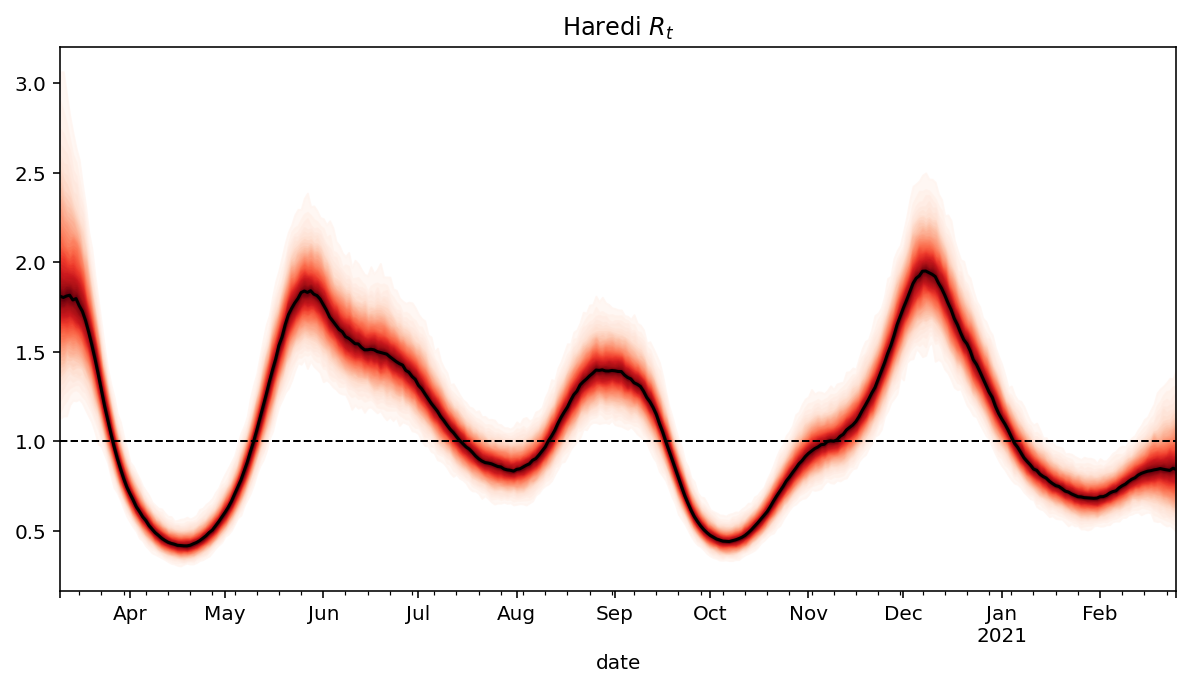

In [4]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"Haredi $R_t$")
samples = gmbb.trace['r_t']
x=resultbb.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

resultbb["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
fig.set_facecolor('w')

In [5]:
resultbb.tail(60)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2021-01-06,0.969146,0.965418,0.832159,1.088933,1318.268259,987.951309,1010.0,1010.0,500000
2021-01-07,0.944030,0.936246,0.808271,1.060365,1319.502891,1036.300738,1024.0,1024.0,500000
2021-01-08,0.917055,0.906491,0.790544,1.044429,1313.151997,1080.948152,1117.0,1117.0,500000
2021-01-09,0.892467,0.886089,0.754748,1.001666,1300.073705,1121.242838,491.0,491.0,500000
2021-01-10,0.871803,0.867232,0.749661,0.992879,1280.444714,1156.570426,1251.0,1251.0,500000
2021-01-11,0.851890,0.844273,0.735973,0.968330,1254.587499,1186.422849,1537.0,1537.0,500000
2021-01-12,0.837206,0.836597,0.712453,0.944096,1223.451428,1210.441610,1283.0,1283.0,500000
2021-01-13,0.821113,0.815649,0.694023,0.931089,1187.920758,1228.388444,1885.0,1885.0,500000
2021-01-14,0.806862,0.802561,0.682782,0.916921,1149.103892,1240.127900,1418.0,1418.0,500000


# General population

In [ ]:
gn = ['5000', '8400', '8300', '1139', '2800', '9000', '2600', '6500', '6600', '6200', '9500']
model_gn = dfcit.loc[gn].groupby('date').sum()
gmgn = GenerativeModel(gn, model_gn, buffer_days = 10, delay=2, sigma=0.07)
gmgn.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


In [ ]:
resultgn = summarize_inference_data(gmgn.inference_data)

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title("General sector")
resultgn.test_adjusted_positive.plot(c="g", label="Test-adjusted")
#resultgn.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
resultgn.infections.plot(c="b", label="Infections")
gmgn.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
#d = gmgn.observed.deaths * 100
#d.plot(c='k', alpha=0.5, label="Reported deaths (x100)")
fig.set_facecolor('w')
plt.yscale("log")
ax.legend();

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"General sector $R_t$")
samples = gmgn.trace['r_t']
x=resultgn.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

resultgn["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
fig.set_facecolor('w')

In [ ]:
resultgn.tail(60)

# Arab cities

In [ ]:
ar = ['472', '2710', '6000', '2730', '2720', '8900', '509', '634', '7300', '7500', '531', '637', '638', '543', '8800']
model_ar = dfcit.loc[ar].groupby('date').sum()
gmar = GenerativeModel(ar, model_ar, buffer_days = 10, delay=2, sigma=0.07)
gmar.sample()

In [ ]:
resultar = summarize_inference_data(gmar.inference_data)

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title("Arab population")
resultar.test_adjusted_positive.plot(c="g", label="Test-adjusted")
#resultar.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
resultar.infections.plot(c="b", label="Infections")
gmar.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
plt.yscale("log")
fig.set_facecolor('w')
ax.legend();

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"Arab population $R_t$")
samples = gmar.trace['r_t']
x=resultar.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

resultar["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
fig.set_facecolor('w')

In [ ]:
resultar.tail(60)

In [ ]:
jr = ['3000']
model_jr = dfcit.loc[jr].groupby('date').sum()
gmjr = GenerativeModel(jr, model_jr, buffer_days = 10, delay=2)
gmjr.sample()

In [ ]:
resultjr = summarize_inference_data(gmjr.inference_data)

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title("Jerusalem")
resultjr.test_adjusted_positive.plot(c="g", label="Test-adjusted")
#resultjr.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
resultjr.infections.plot(c="b", label="Infections")
gmjr.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
d = gmjr.observed.deaths * 100
#d.plot(c='k', alpha=0.5, label="Reported deaths (x100)")
plt.yscale("log")
fig.set_facecolor('w')
ax.legend();

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"Jerusalem $R_t$")
samples = gmjr.trace['r_t']
x=resultjr.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

resultjr["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
fig.set_facecolor('w')

In [ ]:
resultjr.tail(60)

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title(f"$R_t$ estimate")
resultar["median"].plot(c="g", ls='-', label="Arab sector")
resultgn["median"].plot(c="b", ls='-', label="General sector")
resultbb["median"].plot(c="m", ls='-', label="Haredi sector")
resultjr["median"].plot(c="c", ls='-', label="Jerusalem")
ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
ax.legend()

In [ ]:
resultar.to_csv("results_arab_cities_out.csv")
resultbb.to_csv("results_haredi_cities_out.csv")
resultgn.to_csv("results_general_cities_out.csv")
resultjr.to_csv("results_jerusalem_out.csv")

In [ ]:
gush = ["3604", "3618", "3650", "3794", "3603", "3488", "3561", "3653", "3725", "3726", "1982", "1981", "3781", "3602", "3563"]
gush = set(gush) & set(list(dfcit.index.unique(0)))
print(gush)
model_gs = dfcit.loc[gush].groupby('date').sum()
gmgs = GenerativeModel(gush, model_gs, buffer_days = 10, delay=2, sigma=0.07)
gmgs.sample()

resultgs = summarize_inference_data(gmgs.inference_data)

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title("Gush Etsion")
resultgs.test_adjusted_positive.plot(c="g", label="Test-adjusted")
#resultbb.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
resultgs.infections.plot(c="b", label="Infections")
gmgs.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
#d = gmbb.observed.deaths * 100
#d.plot(c='k', alpha=0.5, label="Reported deaths (x100)")
fig.set_facecolor('w')
#plt.yscale("log")
ax.legend();

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"Gush Etsion $R_t$")
samples = gmgs.trace['r_t']
x=resultgs.index
colmap = plt.get_cmap("Reds")
ax.fill_between(x, resultgs["upper_80"], resultgs["lower_80"], color=colmap(50), alpha=.8)
resultgs["median"].plot(c=colmap(90), ls='-', label="Rt using infected")
ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
fig.set_facecolor('w')
plt.grid(which='major', axis='y', ls=':')
